In [4]:
import os
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.constants import CACHE_PATH
from MaStarChecks.constants import INDOUS_FWHM, MILES_FWHM, MASTAR_FHWM
from MaStarChecks.common import get_grid
from MaStarChecks.preprocessing import downgrade_resolution
from MaStarChecks.stellarLibraries.catalogues import build_indous_catalogue, build_miles_catalogue, build_mastar_catalogue
from MaStarChecks.stellarLibraries.spectra import load_indous_seds, load_miles_seds, load_mastar_seds

from MaStarChecks.plotting import triang_plot

from scipy.interpolate import griddata

In [5]:
# read all reliable stellar SED libraries
# read all parameters asigned to those SEDs
# implement a bayesian method for parameter estimation:
#   * preprocess all SEDs so they are in the same reference wl and flux units
#   * build prior probability distributions using the known stellar libraries
#   * build the likelihood function of one given model
#   * explore the parameter space in a bayesian sense, updating the posterior PDF

In [6]:
wl_new, X, e, M, Y, mastar_target = pickle.load(open(os.path.join(CACHE_PATH, "rs-wl_X_e_M_y_mastar_target.p"), "rb"))

X = X.astype(float)
e = e.astype(float)
M = M.astype(float)
Y = Y.astype(float)
mastar_target = mastar_target.astype(float)

Y.dropna(how="any", axis="index", inplace=True)
Y["Teff"] = np.log10(Y["Teff"])
M = M.loc[Y.index]

mastar_target.dropna(how="any", axis="index", inplace=True)
mastar_target["Teff"] = np.log10(mastar_target["Teff"])
X = X.loc[mastar_target.index]

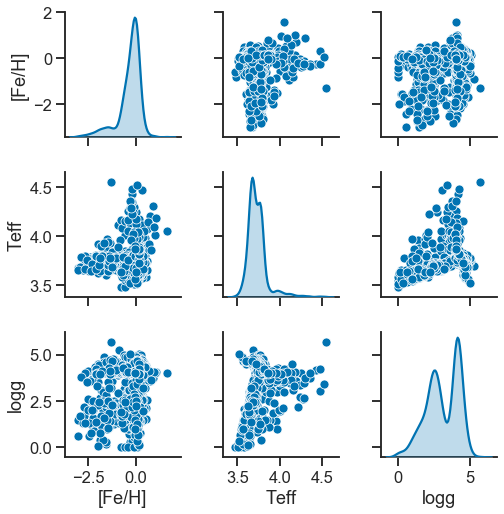

In [7]:
sns.pairplot(Y, diag_kind="kde", palette="plasma")
plt.savefig("mastar-prior.png", bbox_inches="tight")

[Fe/H]   -0.454675
Teff     -0.012655
logg     -1.035982
dtype: float64

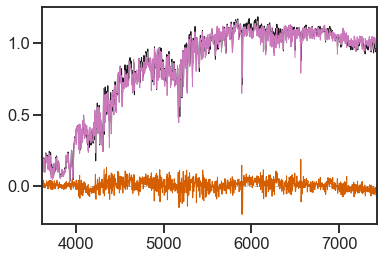

In [8]:
winner_name = "7-9898583"
mastar_target.loc[winner_name]
chis = ((M - X.loc[winner_name][None, :]) ** 2 / e.loc[winner_name][None, :] ** 2).sum(axis="columns") / ((X.loc[winner_name].fillna(0.0) > 0).sum() - 1)
X.loc[winner_name].plot(use_index=True, lw=1, color="k")
M.loc[chis.idxmin()].plot(use_index=True, lw=1, color="m")
plt.axhline(ls="--", lw=1, color="0.7")
(X.loc[winner_name] - M.loc[chis.idxmin()]).plot(use_index=True, lw=1, color="r")
plt.xlim(wl_new.min(), wl_new.max())
Y.loc[chis.idxmin()] - mastar_target.loc[winner_name]

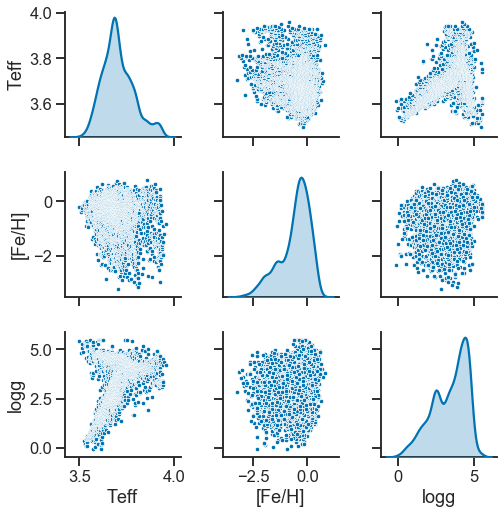

In [9]:
columns = ["Teff", "[Fe/H]", "logg"]
clean_par = mastar_target.filter(items=columns)[columns]
clean_par = clean_par.sort_values(by=columns).dropna(how="any")

sns.pairplot(clean_par, diag_kind="kde", plot_kws={"s": 20})

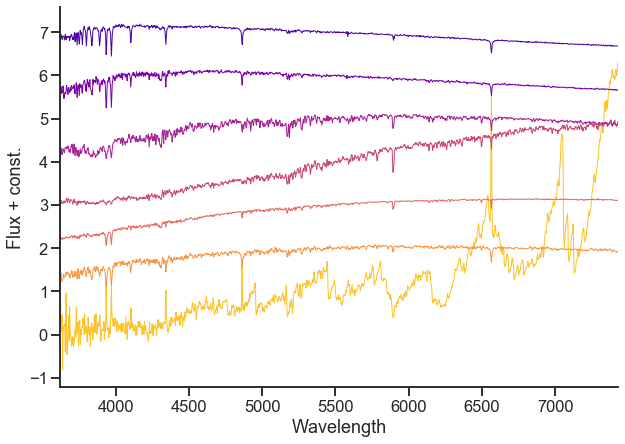

In [10]:
sel_spec = clean_par.index[::500]

colors = sns.color_palette("plasma_r", sel_spec.size)

fig, ax = plt.subplots(figsize=(10,7))

for i, name in enumerate(sel_spec):
    (X.loc[name]+i).plot(use_index=True, lw=1, color=colors[i])
    
sns.despine()
ax.set_xlabel("Wavelength")
ax.set_ylabel("Flux + const.")
fig.savefig("mastar-seds.png", bbox_inches="tight")

In [11]:
def loss(z):
    return np.log(1 + z)

def loss(z):
    return z

if os.path.isfile(os.path.join(CACHE_PATH, "stellar-fitting-chi_rd.p")):
    chi_rd = pickle.load(open(os.path.join(CACHE_PATH, "stellar-fitting-chi_rd.p"), "rb"))
    chi_rd = chi_rd.astype(float)
else:
    chi_rd = pd.DataFrame(index=X.index, columns=M.index)
    for sed_name in tqdm(X.index, desc="SED fitting MaStar", unit="SED"):
        ind_chi = loss((M - X.loc[sed_name][None, :]) ** 2 / e.loc[sed_name][None, :] ** 2)
        chi_sq = ind_chi.sum(axis="columns")

        chi_rd.loc[sed_name, :] = chi_sq / (wl_new.size - 1 - 3)
    
    chi_rd = chi_rd.astype(float)
    pickle.dump(chi_rd, open(os.path.join(CACHE_PATH, "stellar-fitting-chi_rd.p"), "wb"))

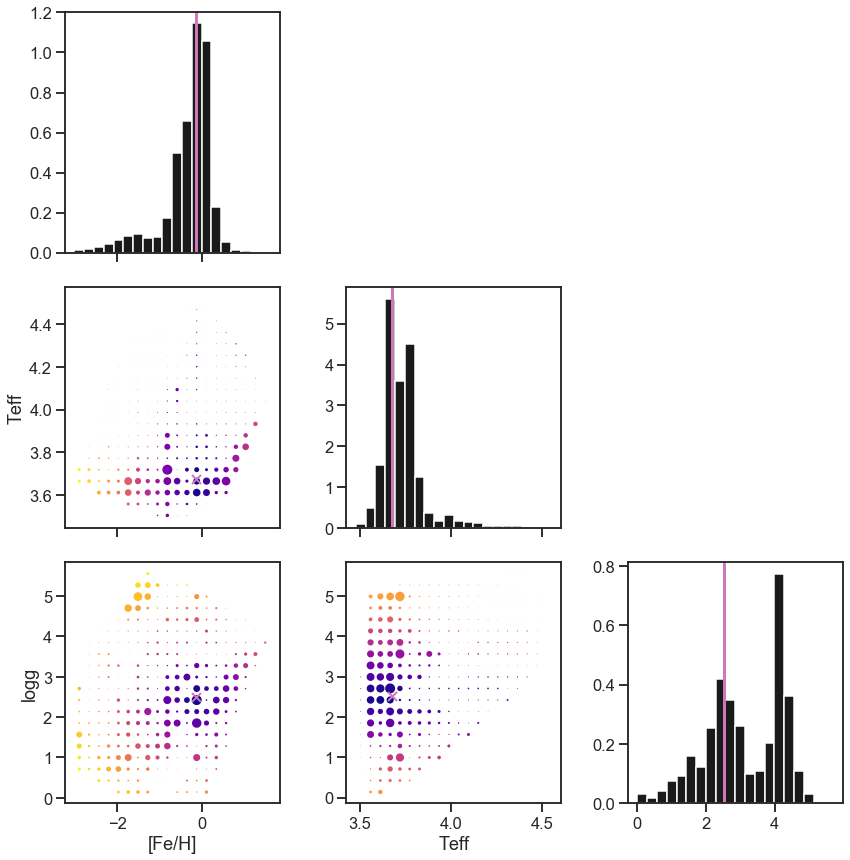

In [12]:
ised = 4
labels = ["[Fe/H]", "Teff", "logg"]
z = 1/chi_rd.iloc[ised].values
true = mastar_target.iloc[ised]

fig = triang_plot(Y, labels, z, true)
fig.savefig("mastar-loglik.pdf", bbox_inches="tight")

In [13]:
# x = Y["[Fe/H]"].values
# y = Y["Teff"].values
# z = Y["logg"].values
# p = chi_rd.iloc[0].values.astype(float)

# ngrid = 20
# xe = get_grid(x, ngrid+1)
# ye = get_grid(y, ngrid+1)
# ze = get_grid(z, ngrid+1)
# xi = 0.5 * (xe[1:] + xe[:-1])
# yi = 0.5 * (ye[1:] + ye[:-1])
# zi = 0.5 * (ze[1:] + ze[:-1])
# ni, _ = np.histogramdd((x,y), bins=(xe,ye))
# ni /= ni.max()

# triang = tri.Triangulation(x, y)
# interpolator = tri.LinearTriInterpolator(triang, p)
# Xi, Yi = np.meshgrid(xi, yi)
# Pi = interpolator(Xi, Yi)

# g = sns.PairGrid(iris)
# g = g.map_lower(plt.scatter, lw=0, s=5, edgecolor="w")
# g = g.map_diag(sns.kdeplot, lw=1.5)

# for i, j in zip(*np.triu_indices_from(g.axes, 1)):
#     g.axes[i, j].set_visible(False)